<a href="https://colab.research.google.com/github/olonok69/LLM_Notebooks/blob/main/nlp/fine_tune_sentence_transformers_gtr_t5_large_classification_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In this Notebook we are going to Fine tune a T5 fundation LLM model with your own data


Model

https://huggingface.co/docs/transformers/model_doc/t5


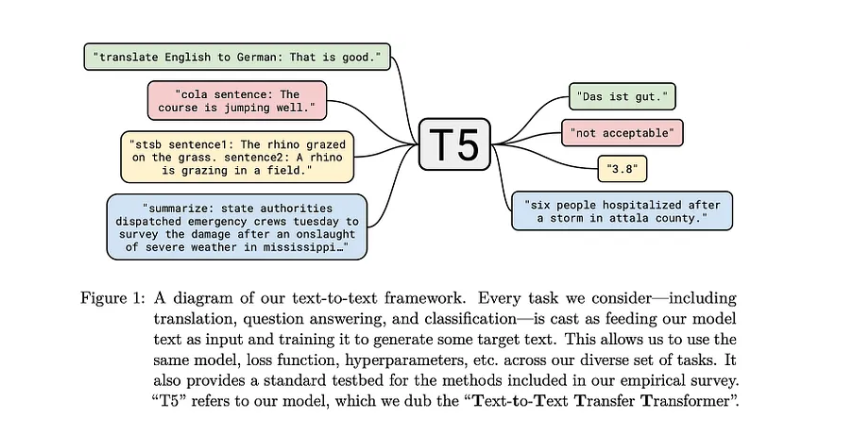![image.png](attachment:9d8eb8cd-1f90-41c2-97a6-a07afd906541.png)


https://arxiv.org/pdf/1910.10683.pdf

https://huggingface.co/google/flan-t5-base


from Cameron R. Wolfe, Ph.D.

https://towardsdatascience.com/t5-text-to-text-transformers-part-one-6b655f27c79a#:~:text=T5%20converts%20all%20text%20processing,tasks%20with%20a%20shared%20approach.

# fine tuned flan-T5

https://blog.research.google/2021/10/introducing-flan-more-generalizable.html

https://huggingface.co/docs/transformers/model_doc/flan-t5

https://arxiv.org/pdf/2210.11416.pdf

https://www.narrativa.com/flan-t5-a-yummy-model-superior-to-gpt-3/

# Flan Dataset

https://medium.com/dair-ai/papers-explained-46-flan-1c5e0d5db7c9


# Dataset use for Fine Tuning

https://www.kaggle.com/datasets/jensenbaxter/10dataset-text-document-classification

# Final Dataset

Microsoft Purview -- > https://learn.microsoft.com/en-us/purview/classifier-tc-definitions#trainable-classifiers-definitions


In [1]:
! pip install  evaluate==0.4.1 wandb accelerate  transformers[torch] -q

# Create Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

from datasets import ClassLabel, Dataset, Features, Image, Value, Sequence, DatasetDict
label_dic={"business":0,"entertainment":1,"food":2,"graphics":3,"historical":4,"medical":5,"politics":6,"space":7,"sport":8,"technologie":9}


Clabels= ClassLabel(num_classes=10, names=["business","entertainment","food","graphics","historical","medical","politics","space","sport","technologie"])


df = pd.read_csv("/content/drive/MyDrive/data/documents_raw.csv")
df = df[["Class", "Document"]]
df['label2']= df['Class'].map(label_dic)

In [4]:
df.head(2)

,Class,Document,label2
0,space,series linked messages periodically posted att...,7
1,space,article according iau circular comet may tempo...,7


In [5]:
list_text= df["Document"].to_list()
list_labels=df["Class"].to_list()
list_labels2=df["label2"].to_list()

In [6]:
stratify_column_name = "label2"
dtrain= { "text": list_text, "label2": list_labels2, "label":list_labels}
dataset = Dataset.from_dict(mapping=dtrain, features=Features({"text":  Value(dtype='string', id=None), "label2": Value(dtype='int8'), 'label': Value(dtype='string', id=None)}))

dataset = dataset.shuffle(seed=42)
dataset = dataset.class_encode_column(stratify_column_name).train_test_split(test_size=0.3)
dataset = dataset.cast_column("label2", Clabels)

Stringifying the column:   0%|          | 0/1000 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/1000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/700 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/300 [00:00<?, ? examples/s]

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label2', 'label'],
        num_rows: 700
    })
    test: Dataset({
        features: ['text', 'label2', 'label'],
        num_rows: 300
    })
})

In [8]:
import evaluate
import nltk
import numpy as np
import torch
from typing import List, Tuple
from nltk.tokenize import sent_tokenize
from datasets import Dataset, concatenate_datasets
from huggingface_hub import HfFolder
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    T5Tokenizer,
    T5ForConditionalGeneration
)

MODEL_ID = "sentence-transformers/gtr-t5-large"

In [9]:
dataset['train'][1]

{'text': 'taxes must trusted trust taxes breaking labour tories straight people lib dem leader charles kennedy day ahead mr kennedy used speech say party facing economic said current level taxation although would put new tax top parties accused lib dems making uncosted mr kennedy made clear determined counter lib dems already published say full costings plans speech announce new commonwealth mr kennedy said critical political party economic promised expected add tough choices needed public lib dems would cut including id cards scheme child trust cutbacks would free funds increasing basic state pensions putting police streets reintroducing fee eye dental lib dems argue honest taxes past calling 1p rise income say simple tax rise want new tax band top earners pay scrapping university tuition providing free personal care elderly disabled people keeping local taxes would also local income tax replace council tax number changes environmental taxes ensure lib dems say tories laid possible op

In [10]:
PROJECT = "FlanT5-Document-Classification"
MODEL_NAME = 'sentence-transformers/gtr-t5-large'
DATASET = "Kaggle-1000-Documents-10-classes"
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

##### https://www.kaggle.com/datasets/jensenbaxter/10dataset-text-document-classification

Classes : business, entertainment,food, graphics, historical, medical, politics, space, sport, technologie


# Model
https://huggingface.co/docs/transformers/model_doc/t5


*Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer*

https://arxiv.org/pdf/1910.10683.pdf

In [11]:
from google.colab import userdata

wandb_key = userdata.get('WANDB')

In [12]:
import wandb
wandb.login(key=wandb_key)
with wandb.init(project=PROJECT,tags=[MODEL_NAME, DATASET],notes ="Fine tuning FlanT5 with Kaggle Dataset. 100 Documents 10 classes",job_type="dataset"):
    wbtrain = wandb.Table(data=dataset['train'].to_pandas())
    wbtest = wandb.Table(data=dataset['test'].to_pandas())
    wandb.log({"dialogsum_train": wbtrain})
    wandb.log({"dialogsum_test": wbtest})


wandb: Currently logged in as: olonok (olonok69). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [13]:
len(dataset['test'].to_pandas()['label'].unique())

10

In [14]:
dataset['test'].to_pandas()['label'].value_counts()

historical       40
technologie      34
business         34
entertainment    31
food             31
space            27
sport            26
medical          26
politics         26
graphics         25
Name: label, dtype: int64

In [15]:
dataset['train'].to_pandas()['label'].value_counts()

graphics         75
politics         74
sport            74
medical          74
space            73
entertainment    69
food             69
business         66
technologie      66
historical       60
Name: label, dtype: int64

In [16]:
full = concatenate_datasets([dataset["train"], dataset["test"]])

In [17]:
full[:2]

{'text': ['experiences colonial santanu das gives overview numbers roles colonial troops world war colonial troops serve used factor military conservative estimates well four million men mobilised european american armies first world combatant know daily lived war experiences men former colonies different racial ethnic spite important work done recent first world war social cultural history war still continues maintain neat symmetry war like sites remain contours war modern start look different instead writings ordinary european let alone poet like wilfred owen novelist like erich maria consider memories indian chinese worker african fictional german writer f h grautoff warned war must necessarily set whole world eurocentric whole except ethiopia european rule great britain france controlled two largest colonial would draw extensively war human material various colonies british india contributed largest number approximately million recruited war december dominions nations within britis

In [18]:
# Metric
metric = evaluate.load("f1")

# Tokenizers

large language models process text using tokens, which are common sequences of characters found in a set of text. The models learn to understand the statistical relationships between these tokens, and excel at producing the next token in a sequence of tokens.

https://platform.openai.com/tokenizer

# Autotokenizer

https://huggingface.co/docs/transformers/v4.36.1/en/model_doc/auto#transformers.AutoTokenizer

In [19]:
MODEL_ID = "sentence-transformers/gtr-t5-large"
# # Load tokenizer of FLAN-t5
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)


In [20]:
tokenized_inputs = concatenate_datasets([dataset["train"], dataset["test"]]).map(
    lambda x: tokenizer(x["text"], truncation=True), batched=True, remove_columns=[ 'label', 'label2']
)
max_source_length = max([len(x) for x in tokenized_inputs["input_ids"]])
print(f"Max source length: {max_source_length}")

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Max source length: 512


In [21]:
tokenized_inputs[1]['text']

'taxes must trusted trust taxes breaking labour tories straight people lib dem leader charles kennedy day ahead mr kennedy used speech say party facing economic said current level taxation although would put new tax top parties accused lib dems making uncosted mr kennedy made clear determined counter lib dems already published say full costings plans speech announce new commonwealth mr kennedy said critical political party economic promised expected add tough choices needed public lib dems would cut including id cards scheme child trust cutbacks would free funds increasing basic state pensions putting police streets reintroducing fee eye dental lib dems argue honest taxes past calling 1p rise income say simple tax rise want new tax band top earners pay scrapping university tuition providing free personal care elderly disabled people keeping local taxes would also local income tax replace council tax number changes environmental taxes ensure lib dems say tories laid possible options cut

In [22]:
tokenized_inputs[1]['input_ids']
len(tokenized_inputs[1]['input_ids'])
len(tokenized_inputs[1]['attention_mask'])

348

In [23]:
tokenizer("technologie")

{'input_ids': [3, 13148, 1], 'attention_mask': [1, 1, 1]}

In [24]:
# The maximum total sequence length for target text after tokenization.
# Sequences longer than this will be truncated, sequences shorter will be padded."
tokenized_targets = concatenate_datasets([dataset["train"], dataset["test"]]).map(
    lambda x: tokenizer(x["label"], truncation=True), batched=True, remove_columns=['text', 'label2']
)
max_target_length = max([len(x) for x in tokenized_targets["input_ids"]])
print(f"Max target length: {max_target_length}")

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Max target length: 3


In [25]:
tokenized_targets['input_ids'][:10], full['label'][:10]

([[4332, 1],
  [6525, 1],
  [1035, 1],
  [542, 1],
  [4527, 1],
  [2600, 1],
  [6525, 1],
  [4527, 1],
  [6484, 1],
  [6484, 1]],
 ['historical',
  'politics',
  'medical',
  'food',
  'entertainment',
  'sport',
  'politics',
  'entertainment',
  'graphics',
  'graphics'])

In [26]:
REPOSITORY_ID = f"{MODEL_ID.split('/')[1]}-text-classification"

# Model

In [27]:

# Define training args
training_args = Seq2SeqTrainingArguments(
    output_dir=REPOSITORY_ID,
    per_device_train_batch_size=8,
    #per_device_eval_batch_size=8,
    predict_with_generate=True,
    fp16=False,     # Overflows with fp16
    learning_rate=3e-4,
    num_train_epochs=10,
    logging_dir=f"{REPOSITORY_ID}/logs",    # logging & evaluation strategies
    logging_strategy="epoch",
    evaluation_strategy="no",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=False,
    report_to="wandb",
    push_to_hub=False,
    hub_strategy="every_save",
    hub_model_id=REPOSITORY_ID,

)

def preprocess_function(sample: Dataset, max_target_length: int, padding: str = "max_length") -> dict:
    """ Preprocess the dataset. """

    # add prefix to the input for t5
    inputs = [item for item in sample["text"]]

    # tokenize inputs
    model_inputs = tokenizer(inputs, max_length=max_source_length, padding=padding, truncation=True)

    # Tokenize targets with the `text_target` keyword argument
    labels = tokenizer(text_target=sample["label"], max_length=max_target_length, padding=padding, truncation=True)

    # If we are padding here, replace all tokenizer.pad_token_id in the labels by -100 when we want to ignore
    # padding in the loss.
    if padding == "max_length":
        labels["input_ids"] = [
            [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in labels["input_ids"]
        ]

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


def postprocess_text(preds: List[str], labels: List[str]) -> Tuple[List[str], List[str]]:
    """ helper function to postprocess text"""
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # rougeLSum expects newline after each sentence
    preds = ["\n".join(sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(sent_tokenize(label)) for label in labels]

    return preds, labels


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels, average='macro')
    result = {k: round(v * 100, 10) for k, v in result.items()}
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    return result

In [28]:
tokenized_dataset = dataset.map(preprocess_function, batched=True, remove_columns=['text', 'label','label2'],fn_kwargs={"max_target_length": max_target_length})
print(f"Keys of tokenized dataset: {list(tokenized_dataset['train'].features)}")

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Keys of tokenized dataset: ['input_ids', 'attention_mask', 'labels']


In [29]:
tokenized_dataset['train'][1].keys()

dict_keys(['input_ids', 'attention_mask', 'labels'])

In [30]:
tokenized_dataset['train'][1]['input_ids']
len(tokenized_dataset['train'][1]['input_ids'])

512

In [ ]:
#tokenized_dataset['train'][1]['attention_mask']

# AutoModelForSeq2SeqLM

This is a generic model class that will be instantiated as one of the model classes of the library—with a sequence-to-sequence language modeling head

https://huggingface.co/docs/transformers/model_doc/t5

https://huggingface.co/transformers/v3.5.1/model_doc/auto.html#automodelforseq2seqlm

In [31]:
labels = dataset['train'].features['label2'].names
id2label={str(i): c for i, c in enumerate(labels)}
label2id={c: str(i) for i, c in enumerate(labels)}
id2label

{'0': 'business',
 '1': 'entertainment',
 '2': 'food',
 '3': 'graphics',
 '4': 'historical',
 '5': 'medical',
 '6': 'politics',
 '7': 'space',
 '8': 'sport',
 '9': 'technologie'}

In [32]:
label2id

{'business': '0',
 'entertainment': '1',
 'food': '2',
 'graphics': '3',
 'historical': '4',
 'medical': '5',
 'politics': '6',
 'space': '7',
 'sport': '8',
 'technologie': '9'}

In [34]:
# load model from the hub
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_ID, num_labels=len(labels),
                                              torch_dtype=torch.bfloat16,
     id2label={str(i): c for i, c in enumerate(labels)},
     label2id={c: str(i) for i, c in enumerate(labels)},)

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/670M [00:00<?, ?B/s]

Some weights of T5ForConditionalGeneration were not initialized from the model checkpoint at sentence-transformers/gtr-t5-large and are newly initialized: ['decoder.block.15.layer.0.layer_norm.weight', 'decoder.block.19.layer.2.layer_norm.weight', 'decoder.block.2.layer.0.SelfAttention.o.weight', 'decoder.block.8.layer.2.DenseReluDense.wi.weight', 'decoder.block.7.layer.0.SelfAttention.v.weight', 'decoder.block.5.layer.2.DenseReluDense.wo.weight', 'decoder.block.17.layer.1.EncDecAttention.v.weight', 'decoder.block.12.layer.1.EncDecAttention.q.weight', 'decoder.block.0.layer.2.layer_norm.weight', 'decoder.block.6.layer.1.EncDecAttention.v.weight', 'decoder.block.22.layer.0.layer_norm.weight', 'decoder.block.16.layer.0.SelfAttention.k.weight', 'decoder.block.14.layer.0.SelfAttention.k.weight', 'decoder.block.19.layer.1.layer_norm.weight', 'decoder.block.8.layer.2.layer_norm.weight', 'decoder.block.16.layer.2.DenseReluDense.wi.weight', 'decoder.block.12.layer.0.SelfAttention.k.weight', 'd

# Data Collator

https://huggingface.co/docs/transformers/main/main_classes/data_collator

In [35]:
nltk.download("punkt")

# we want to ignore tokenizer pad token in the loss
label_pad_token_id = -100
# Data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    label_pad_token_id=label_pad_token_id,
    pad_to_multiple_of=8
)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [36]:
# Create Trainer instance
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_dataset["train"],
    #eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
)

In [37]:
tokenized_dataset["test"]

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 300
})

In [38]:

import torch
import gc
gc.collect()
torch.cuda.empty_cache()

In [39]:
# TRAIN

with wandb.init(project=PROJECT, job_type="train"):
    train_results = trainer.train()
    trainer.save_model()

    trainer.log_metrics("train", train_results.metrics)
    trainer.save_metrics("train", train_results.metrics)
    trainer.save_state()
    print(train_results.metrics)

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
88,15.414800
176,0.241400
264,0.090800
352,0.017200
440,0.009900
528,0.002600
616,0.008100
704,0.000800
792,0.003600
880,0.000000


***** train metrics *****
  epoch                    =       10.0
  total_flos               = 14114501GF
  train_loss               =     1.5789
  train_runtime            = 0:06:21.10
  train_samples_per_second =     18.367
  train_steps_per_second   =      2.309
{'train_runtime': 381.1084, 'train_samples_per_second': 18.367, 'train_steps_per_second': 2.309, 'total_flos': 1.5155331072e+16, 'train_loss': 1.5789121264994306, 'epoch': 10.0}


train/epoch,▁▂▃▃▄▅▆▆▇██
train/global_step,▁▂▃▃▄▅▆▆▇██
train/learning_rate,█▇▆▆▅▄▃▃▂▁
train/loss,█▁▁▁▁▁▁▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁
train/train_samples_per_second,▁
train/train_steps_per_second,▁
train/epoch,10.0
train/global_step,880


In [40]:
train_results

TrainOutput(global_step=880, training_loss=1.5789121264994306, metrics={'train_runtime': 381.1084, 'train_samples_per_second': 18.367, 'train_steps_per_second': 2.309, 'total_flos': 1.5155331072e+16, 'train_loss': 1.5789121264994306, 'epoch': 10.0})

In [41]:
!rm -rf /content/drive/MyDrive/models/flan-T5-fine-tune

In [42]:

!mkdir /content/drive/MyDrive/models/flan-T5-fine-tune
custom_path = "/content/drive/MyDrive/models/flan-T5-fine-tune"
trainer.save_model(output_dir=custom_path)

In [43]:
with wandb.init(project=PROJECT, job_type="models"):
    artifact = wandb.Artifact("gtr-T5-fine-tuned", type="model")
    artifact.add_dir(custom_path)
    wandb.save(custom_path)
    wandb.log_artifact(artifact)

wandb: Adding directory to artifact (/content/drive/MyDrive/models/flan-T5-fine-tune)... Done. 4.9s
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


In [44]:
tokenizer.save_pretrained(REPOSITORY_ID)

('gtr-t5-large-text-classification/tokenizer_config.json',
 'gtr-t5-large-text-classification/special_tokens_map.json',
 'gtr-t5-large-text-classification/spiece.model',
 'gtr-t5-large-text-classification/added_tokens.json',
 'gtr-t5-large-text-classification/tokenizer.json')

# *Uncomment to push to HF*


In [ ]:
# tokenizer.save_pretrained(REPOSITORY_ID)
# trainer.create_model_card()
# trainer.push_to_hub()

In [45]:
import torch
from tqdm.auto import tqdm


from sklearn.metrics import classification_report



# Load model and tokenizer from the hub
#tokenizer = AutoTokenizer.from_pretrained(f"/kaggle/working/{REPOSITORY_ID}")
tokenizer = T5Tokenizer.from_pretrained(f"/content/{REPOSITORY_ID}")

#model = AutoModelForSeq2SeqLM.from_pretrained(custom_path)
model = T5ForConditionalGeneration.from_pretrained(custom_path, num_labels=len(labels),
     id2label={str(i): c for i, c in enumerate(labels)},
     label2id={c: str(i) for i, c in enumerate(labels)},)

model = model.to('cuda') if torch.cuda.is_available() else model.to('cpu')

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [46]:
def classify(text_to_classify: str) -> str:
    """Classify a text using the model."""
    inputs = tokenizer.encode_plus(text_to_classify, padding='max_length', max_length=512, return_tensors='pt')
    inputs = inputs.to('cuda') if torch.cuda.is_available() else inputs.to('cpu')
    outputs = model.generate(inputs['input_ids'], attention_mask=inputs['attention_mask'], max_length=3)#, num_beams=4, early_stopping=True)
    prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return prediction


def evaluate_model() -> None:
    """Evaluate the model on the test dataset."""
    predictions_list, labels_list = [], []

    samples_number = len(dataset['test'])
    progress_bar = tqdm(range(samples_number))

    for i in range(samples_number):
        text = dataset['test']['text'][i]
        predictions_list.append(classify(text))
        labels_list.append(str(dataset['test']['label'][i]))

        progress_bar.update(1)

    report = classification_report(labels_list, predictions_list, zero_division=0)
    print(report)

In [47]:
 evaluate_model()

  0%|          | 0/300 [00:00<?, ?it/s]

               precision    recall  f1-score   support

     business       0.97      0.88      0.92        34
entertainment       1.00      1.00      1.00        31
         food       0.91      1.00      0.95        31
     graphics       1.00      1.00      1.00        25
   historical       0.95      0.97      0.96        40
      medical       1.00      0.88      0.94        26
     politics       0.96      0.92      0.94        26
        space       0.93      1.00      0.96        27
        sport       1.00      1.00      1.00        26
  technologie       0.94      0.97      0.96        34

     accuracy                           0.96       300
    macro avg       0.97      0.96      0.96       300
 weighted avg       0.96      0.96      0.96       300



In [48]:
text_to_classify ="""As 2023 draws to a close, we’ve been looking back on the year as it unfolded in UK and world politics.

While many may have expected a quieter year in UK politics, the year of 2023 didn’t fail to keep the headlines flowing. Events in the UK also happened amid an already and increasingly challenging context in international politics, with new conflicts breaking out this year. Looking forward, 2024 is set to be a major year for politics, with two key elections expected in the UK and US, against a backdrop of significant challenges across the world.

Month by month, this is a summary of some of the key political stories that got people talking, drove change and impacted people’s lives in 2023…

January
Strikes – The UK Government published a bill in Parliament designed to require organisations in the public sector to provide a minimum level of service in the event of strikes by workers. The move came during a month in which workers for various services walked out over numerous disputes – workers to strike included rail workers, NHS staff, DVLA staff, DWP staff, bus drivers, legal advisers and more. There was even greater impacts from strike action in March.

Gender Recognition Reform Bill – The UK Government announced it would block a bill passed by the Scottish Parliament seeking to make it simpler for people to change their legal gender. The bill was blocked under a section 35 order of the 1998 Scotland Act to stop the bill receiving royal assent – the first time such an order is thought to have been made.

International – Luiz Inácio Lula da Silva was sworn in as the President of Brazil."""

In [51]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [52]:
from nltk.corpus import stopwords
import nltk

def pre_process_text(text_to_classify):
    tokens = text_to_classify.split(" ")
    tokens_pun_lower = [i.lower() for i in tokens if i.isalnum()]
    stop_words = stopwords.words('english')
    tokens_stop = [i for i in tokens_pun_lower if i not in stop_words]
    text_to_class = " ".join(tokens_stop)
    return text_to_class

In [53]:
text_to_class = pre_process_text(text_to_classify)

In [54]:
classify(text_to_class)

'politics'